<a href="https://colab.research.google.com/github/juccaicedoac03/Computer_Vision_Course/blob/main/1_Conceptos_preliminares/Autodiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión Lineal regularizada (Ridge regression)

Asumimos:

$$\hat{y}=f(X)=Xw$$

Función de costo: 

$$ \mathcal{L}: \|Xw-y\|^2_2+\lambda\|w\|^2_2$$

Problema de optimización:

$$w^* = \arg \min_w \mathbb{E}_{p(X,y)}\{\|Xw-y\|^2_2\}+\lambda\|w\|^2_2$$

Derivada de la función de costo:

$$\nabla_w\mathcal{L}(f(X|w),y)=2\left(X^\top\left(Xw-y\right)+\lambda w\right)$$

Recordemos que:

$X\in\mathbb{R}^{N \times P},$  $w\in\mathbb{R}^{P\times 1},$ $y,\hat{y}\in\mathbb{R}^{N\times 1},$

donde para el ejercicio $N=500$ y $P=1$

## Solución analítica

$$w^* = \left(X^\top X+\lambda I\right)^{-1}X^\top y$$

## Por gradiente descendiente

$$w_i = w_{i-1} - \eta_i \nabla_w\mathcal{L}(f(X|w_{i-1}),y)$$

## La diferenciación automática (algorítmica) estima 
$$\nabla_w\mathcal{L}(f(X|w_{i-1}),y)$$

# Ejercicio: Resolver el problema de regresión de las 3 soluciones

Importamos librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Creamos datos sintéticos

In [2]:
N = 500 # número de muestras

x = np.linspace(-5,5,N) # datos

# pesos, recordemos que: y = w1*x + w0
w1 = 2
w0 = -1

# Forma matricial
Xdata = np.c_[x.reshape(-1,1),np.ones((N,1))]
w = np.array([w1,w0]).reshape(-1,1)
y = Xdata.dot(w) # 500 x2  x 2  x 1

# Agregamos ruido 
var = 0.8
noise = np.sqrt(var)*np.random.randn(N)
yn = y + noise.reshape(-1,1)

print(Xdata.shape, yn.shape)

(500, 2) (500, 1)


## Ejercicio: Escribir un código para encontrar la solución analítica del problema de regresión (Solución 1): 

In [ ]:
# Escribir tu código aquí
# NOTA: imprimir y graficar la solución


## Solución 2: Enfoque de optimización por mini lotes

<center>
<figure>
<img src='https://miro.medium.com/v2/resize:fit:4800/1*Fg89isxWq_CuNekuMEMAVQ.gif' width="500"> 

Source: https://towardsdatascience.com/how-to-train-neural-network-faster-with-optimizers-d297730b3713
</center>


La idea de los mini lotes es recorrer varias veces (epochs) los datos particionados en segmentos más pequeños (bathces) y calcular el gradiente de la función de costo en cada iteración.

In [4]:
#training
epochs = 50 # número de iteraciones
batch_size = 32 # cantidad de muestras en un batch

lr = 1e-4  #hyperparametro learning rate

we = np.random.randn(2).reshape(-1,1)  # inicializamos los pesos
loss = np.zeros((epochs)) # inicializamos la perdida en ceros
lamb = 1e-1 # hyperparametro regularizacion

wM = np.zeros((epochs,len(we))) # creamos variable para guardar los valores de los pesos en cada epoca
 
Niter = int(Xdata.shape[0]/batch_size) #N iteraciones por epoch

for epoch in range(epochs): #epochs
  for i in range(1,Niter+1): #iterar por bathces en epoch
    Xbatch = Xdata[(i-1)*batch_size:i*batch_size,:]
    yn_batch = yn[(i-1)*batch_size:i*batch_size]
    ye_batch = (Xbatch.dot(we)).reshape(-1,1)
    grad = (2*Xbatch.T).dot(ye_batch-yn_batch) + 2*lamb*we# derivada de la función de costo
    we = we - lr*grad
  loss[epoch] = np.linalg.norm(yn_batch-ye_batch) + lamb*np.linalg.norm(we)
  wM[epoch] = we.reshape(1,-1)
    
print('Pesos originales', w.T)
print('Pesos estimados',we.T)

Pesos originales [[ 2 -1]]
Pesos estimados [[ 2.0252473 -0.9968141]]


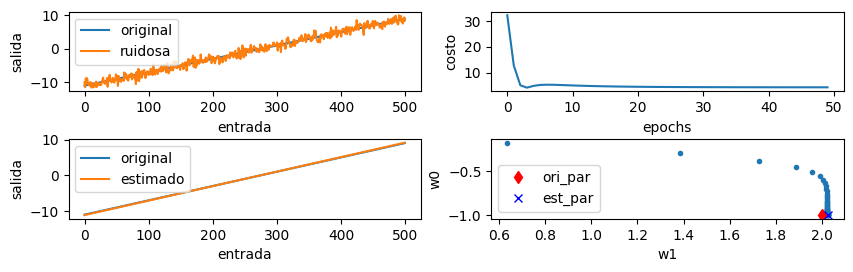

In [8]:
plt.figure(figsize=(10,6))

plt.subplot(421)
plt.plot(y, label = 'original')
plt.plot(yn,label = 'ruidosa')
plt.xlabel('entrada')
plt.ylabel('salida')
plt.legend()

plt.subplot(422)
plt.plot(np.arange(epochs),loss)
plt.xlabel('epochs')
plt.ylabel('costo')


plt.subplot(423)
plt.plot(y, label = 'original')
ye = Xdata.dot(we)
plt.plot(ye, label = 'estimado')
plt.xlabel('entrada')
plt.ylabel('salida')
plt.legend()


plt.subplot(424)
plt.plot(wM[:,0],wM[:,1],'.' )
plt.plot(w[0],w[1],'rd',label='ori_par' )
plt.plot(we[0],we[1],'bx',label='est_par' )


plt.xlabel('w1')
plt.ylabel('w0')
plt.legend()


plt.subplots_adjust(wspace=0.2,hspace=0.6)
plt.show()

## Usando Autodiff por medio de tensorflow

In [9]:
import tensorflow as tf

Convertimos todos los arreglos a tensores.

ver: https://www.tensorflow.org/api_docs/python/tf

In [16]:
Xdata_tf = tf.convert_to_tensor(Xdata,dtype=tf.float32)
yn_tf = tf.convert_to_tensor(yn,dtype=tf.float32)
we_tf = tf.Variable(tf.random.normal((2, 1),dtype=tf.float32))

print(Xdata_tf.shape)
print(yn_tf.shape)
print(we_tf.shape)

(500, 2)
(500, 1)
(2, 1)


Definimos la función de costo que queremos derivar como una función de python

In [17]:
#funcion de perdida a derivar
def l(w,X,y,lam=1e-3): # Los parámetros son todos los datos que interfieren en la función de costo
    e = y-tf.linalg.matmul(X,w) # Ahora las operaciones se deben hacer entre tensores usando tensorflow
    return tf.linalg.matmul(e,e,transpose_a=True)+  lam*tf.linalg.matmul(we_tf,we_tf,transpose_a=True)

In [18]:
# Ejemplo, Calculamos el costo inicial:
z=l(we_tf,Xdata_tf,yn_tf) 

print('Costo=',z.numpy()[0])

Costo= [8546.456]


Cálculamos el gradiente con autodiff

In [19]:
#calculo gradient con autodiff
lr = tf.constant(1e-4,dtype=tf.float32) # definimos la tasa de aprendizaje

with tf.GradientTape() as tape: #crear contexto gradient tape para guardar cada operacion que envuelve una variable
    z=l(we_tf,Xdata_tf,yn_tf) #funcion de perdida (loss) para salvar memoria colocar la menor cantidad de codigo en el tape

gradients = tape.gradient(z,[we_tf]) # tape calcula  los gradientes del resultado z con respecto a [w1,w2]

print('gradiente=',gradients[0].numpy().T) #gradient tape hace los calculos una sola vez de forma inversa sin importar la cantidad de variables
print('wi=',we_tf.numpy().T)
we_tf.assign_sub(lr*gradients[0]) # es igual a we_tf -= lr*gradients[0]#tf.Variable(we_tf - lr*gradients[0],dtype=tf.float32) --> fórmula del gradiente descendente
print('wi-lr*gwi=',we_tf.numpy().T)

gradiente= [[-10443.627   1820.141]]
wi= [[0.7772987  0.81472945]]
wi-lr*gwi= [[1.8216614  0.63271534]]


## Ejercicio: Escribir un código que permita resolver el problema de regresión lineal mediante optimización por mini lotes y usando Autodiff para calcular automáticamente el gradiente (Solución 3).

In [ ]:
# Escribir tu código aquí
# NOTA: imprimir y graficar la solución


# Ejercicio: Resolver el problema de regresión mediante los 3 tipos de solución para datos con N=800 y P= 8

## Solución 1

In [ ]:
# Escribir tu código aquí
# NOTA: imprimir y graficar la solución


## Solución 2

In [ ]:
# Escribir tu código aquí
# NOTA: imprimir y graficar la solución


# Solución 3

In [ ]:
# Escribir tu código aquí
# NOTA: imprimir y graficar la solución
